In [1]:
import pandas as pd
import numpy as np
from libs.utils import fix_continent_matches, cumsum_graph, format_dataframe, get_continent_from_fifa, check_records_validity, convert_onehot, convert_onehot_simplified
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from os import path
from scipy.stats import spearmanr, pearsonr, kendalltau
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn import preprocessing, linear_model
from scipy.stats import zscore
from scipy.stats import poisson

plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize':(45,10), 'figure.dpi':100})

PATH_ORIGINAL_DST = 'dataset/original'
PATH_DST = 'dataset'

## Parte 1: Introduzione dataset, verifica e preparazione

Si prende in analisi un dataset contenente 4483 risultati di partite di calcio internazionale maschile.<br>
L'obbiettivo è realizzare un predittore di risultati di partite di calcio internazionale [... aggiungi descrizione dal dataset stesso...]. Inizialmente viene preso in esame il dataset, vengono estratte alcune informazioni utilizzando la statistica descrittiva.<br>
Per prima cosa verifico l'eventuale presenza di valori nulli del dataset

In [2]:
df = pd.read_csv(path.join(PATH_ORIGINAL_DST ,'results.csv') )

print("Null values:", df.isnull().values.any(), "| shape:", df.shape)
print("***"*15)
print(df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Pre-processing
Dopo essermi accertato che il dataset non contiene elementi nulli procedo con il pre-processing:
- Estraggo la data dalla colonna `date` in rispettivamente in `day` `day_of_week` `month` `year`:
- Calcolo `outcome` dall'incontro utilizzando la funzione `return_outcome` che ritorna `Home` per vittoria della squadra di casa, `Draw` per il pareggio e `Away` per vittoria della squadra ospite
- Converto il valore `home_score` e `away_score` in `float` (servirà successivamente)
- Alcuni nomi di nazioni sono cambiate nel tempo, in quanto il dataset presenta incontri che comprendono ad ese
- Formatto i nomi delle nazioni [scrivi meglio]

In [3]:
df = format_dataframe(df)

Solitamente, nel calcio, la prima squadra è considerata sempre quella di casa. Controllo dunque che il dataset sia coerente con questa convenzione prima di procedere al calcolo delle statistiche per ogni team

In [4]:
if len(df.query("away_team == country")) > 0:
    print("Trovati %d record incorenti con la convenzione" % len(df.query("away_team == country")))

Trovati 25 record incorenti con la convenzione


Visto l'esiguo numero di elementi li visualizzo

In [5]:
df.query("away_team == country")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
788,1924-03-13,Catalonia,Spain,0.0,7.0,Friendly,Barcelona,Spain,False,Away,1924
1618,1933-10-04,Silesia,Poland,1.0,2.0,Friendly,Katowice,Poland,False,Away,1933
1650,1934-02-02,Catalonia,Spain,0.0,2.0,Friendly,Barcelona,Spain,False,Away,1934
2754,1947-10-19,Catalonia,Spain,3.0,1.0,Friendly,Barcelona,Spain,False,Home,1947
3487,1953-04-26,Silesia,Poland,2.0,3.0,Friendly,Chorzów,Poland,False,Away,1953
3526,1953-08-09,Catalonia,Spain,0.0,6.0,Friendly,Barcelona,Spain,False,Away,1953
3539,1953-09-13,Silesia,Poland,3.0,3.0,Friendly,Byton,Poland,False,Draw,1953
28848,2006-11-19,Crimea,Northern Cyprus,0.0,5.0,ELF Cup,Lefkoşa,Northern Cyprus,True,Away,2006
28898,2006-12-09,Silesia,Poland,1.0,1.0,Friendly,Chorzów,Poland,False,Draw,2006
31765,2009-10-28,South Africa,Zimbabwe,1.0,1.0,COSAFA Cup,Harare,Zimbabwe,True,Draw,2009


Sono state trovate dunque 25 incoerenze riguardo alla convenzione spiegata sopre. È semplice spiegarle:
- I record che presentano neutral = False: è spiegato dal fatto che la Silesia è oggi parte della Polonia e della Republica Ceca, mentre la Catalonia ad oggi è annessa alla Spagna. Questo sta a dimostrare che sono presenti  dati 'spuri' dal dataset di cui è già stata prevista l'eliminazione in seguito,<br>
- I record che presentano neutral = True sono incoerenti<br>

Sistemo:

In [6]:
for i in df.query("away_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

Controllo che la presenza di ulteriori incoerenze anche nel caso in cui `home_team` sia uguale a `contry` e `neutral` sia uguale a `True`

In [7]:
df.query("home_team == country and neutral == True")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
10966,1979-08-29,Fiji,Papua New Guinea,0.0,0.0,South Pacific Games,Suva,Fiji,True,Draw,1979
35360,2013-07-15,Bermuda,Falkland Islands,8.0,0.0,Island Games,Hamilton,Bermuda,True,Home,2013
40116,2018-09-09,St. Kitts and Nevis,Puerto Rico,1.0,0.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Home,2018
40399,2018-11-18,St. Kitts and Nevis,Canada,0.0,1.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Away,2018
40757,2019-06-07,China PR,Philippines,2.0,0.0,Friendly,Guangzhou,China PR,True,Home,2019
41044,2019-08-11,St. Vincent / Grenadines,Trinidad and Tobago,1.0,0.0,Friendly,Georgetown,St. Vincent / Grenadines,True,Home,2019
41046,2019-08-27,St. Kitts and Nevis,Antigua and Barbuda,4.0,3.0,Friendly,Basseterre,St. Kitts and Nevis,True,Home,2019
41110,2019-09-06,USA,Mexico,0.0,3.0,Friendly,East Rutherford,USA,True,Away,2019
41229,2019-09-18,Congo DR,Rwanda,2.0,3.0,Friendly,Kinshasa,Congo DR,True,Away,2019
42068,2021-03-29,Congo DR,Gambia,1.0,0.0,African Cup of Nations qualification,Kinshasa,Congo DR,True,Home,2021


In [8]:
for i in df.query("home_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

def swap_outcome(val):
    val.replace({"Home": "Away", "Away":"Home"})
    return val

neutral_games = df.query("neutral == True")
not_neutral_games = df.query("neutral == False")

invalid_ = not_neutral_games.query("away_team == country")

invalid_copy = invalid_.copy()

invalid_.loc[invalid_.index.values, 'home_team'] = invalid_copy.loc[invalid_.index.values, 'away_team']
invalid_.loc[invalid_.index.values, 'home_score'] = invalid_copy.loc[invalid_.index.values, 'away_score'] 
invalid_.loc[invalid_.index.values, 'away_team'] = invalid_copy.loc[invalid_.index.values, 'home_team'] 
invalid_.loc[invalid_.index.values, 'away_score'] = invalid_copy.loc[invalid_.index.values, 'home_score'] 
invalid_['outcome'] = invalid_['outcome'].replace({"Home": "Away", "Away":"Home"})

for i in invalid_.index.values:
    df.loc[i, 'home_team'] = invalid_.loc[i, 'home_team']
    df.loc[i, 'home_score'] = invalid_.loc[i, 'home_score']
    df.loc[i, 'away_team'] = invalid_.loc[i, 'away_team']
    df.loc[i, 'away_score'] = invalid_.loc[i, 'away_score']
    df.loc[i, 'outcome'] = invalid_.loc[i, 'outcome']

In [10]:
df.to_csv(path.join(PATH_DST, 'dataset_v1.csv'))

### Check validità match

Controllo la presenza di eventuali record ambigui, data anche la presenza di partite vecchie, ad esempio di nazioni non più presenti... spiega meglio ... non li considero da subito.

Per validare le squadre utilizzerò il dataset FIFA ...descrivi....

In [11]:
len(df)

42483

In [12]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv'))

df = check_records_validity(df, df_fifa)

df_valid = df.query("is_valid == True").drop(columns=['is_valid']).reset_index(drop=True)
df_valid.to_csv(path.join(PATH_DST, "dataset_v1_valid.csv"))
df_not_valid = df.query("is_valid == False").drop(columns=['is_valid']).reset_index(drop=True)
df_not_valid.to_csv(path.join(PATH_DST, "dataset_v1_not_valid.csv"))

if len(df_valid) + len(df_not_valid) == len(df):
    print("valid: %s not valid: %s, totale di record esaminati %s" % ( len(df_valid),len(df_not_valid), len(df) ) )
else:
    print("Something wrong happened!")

Valid country: 216
valid: 41685 not valid: 798, totale di record esaminati 42483


### Check validità nazioni

Dovrebbe servire per dopo nello specifico ma dato che questa è la parte dove pulisco il dataset lo faccio qui...

In [14]:
pd.options.mode.chained_assignment = None  # default='warn'
df_valid_country = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid.csv')).drop(columns=['Unnamed: 0'])

df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv')).drop(columns=['id','rank', 'country_abrv', 'total_points', 'previous_points', 'rank_change', 'rank_date']).sort_values(by='country_full').drop_duplicates().reset_index(drop=True)

df_unvalid_country = pd.DataFrame()

# estraggo tutti i team presenti in dataset_reduced_fixed
df_ht = df_valid_country['home_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'home_team': 'team'})
df_at = df_valid_country['away_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'away_team': 'team'})

# controllo che il numero di squadre sia lo stesso
if df_ht.__len__() != df_at.__len__():
    print("Not same length! Some mismatch")



df_valid_country = pd.concat([df_ht,df_at]).drop_duplicates().sort_values(by='team').reset_index().drop(labels=['index'], axis=1)

df_valid_country['confederation'] = ""

for i, row in df_valid_country.iterrows():
    if(len(df_fifa.query("country_full == @row.team")) > 0):
        df_valid_country.at[i, 'confederation'] = df_fifa.query("country_full == @row.team").confederation.values[0]

df_valid_country.replace("", np.nan, inplace=True)

df_unvalid_country = df_valid_country[df_valid_country['confederation'].isna()]
df_unvalid_country.reset_index(drop=True, inplace=True)
df_unvalid_country.drop(labels=['confederation'], axis=1, inplace=True)

# utilizzo le squadre non presenti in FIFA ranking
df_valid_country.dropna(subset = ['confederation'], inplace=True)
df_valid_country.reset_index(drop=True, inplace=True)

print("... Fixed. Number of teams: %d" % len(df_valid_country))

# salvo i dataframe perché potrebbero servire successivamente
df_valid_country.to_csv(path.join(PATH_DST, 'dataset_v1_valid_country.csv'))
df_unvalid_country.to_csv(path.join(PATH_DST, 'dataset_v1_not_valid_country.csv'))

Not same length! Some mismatch
... Fixed. Number of teams: 209


Procedo con eliminare tutte quei match che presentano squadre in 'df_unvalid_countries_csv' e realizzo la seconda versione del dataset

In [15]:
# per evitare problemi riguardo le variabili reimporto i csv
df = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid.csv')).drop(columns=['Unnamed: 0'])

for index, row in df_unvalid_country.iterrows():
    if(len(df.query("home_team == @row.team or away_team == @row.team")) > 0):
        df.drop(df.query("home_team == @row.team or away_team == @row.team").index.values, inplace=True)
    

print("Now dataset is formed by: %d records"% len(df))

Now dataset is formed by: 39029 records


Controllo che il numero di squadre che ha giocato fuori casa è lo stesso di chi ha giocato in casa ed eventualmente visualizzo

In [16]:
if len(df['home_team'].drop_duplicates().sort_values().values) > len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team > away_team: %s" % list(set(df['home_team'].drop_duplicates().sort_values().values).difference(df['away_team'].drop_duplicates().sort_values().values)))
elif len(df['home_team'].drop_duplicates().sort_values().values) < len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team < away_team: %s" % list(set(df['away_team'].drop_duplicates().sort_values().values).difference(df['home_team'].drop_duplicates().sort_values().values)))
else:
    print("Home teams and away teams are the same")

Mismatch home_team > away_team: ['St. Kitts and Nevis']


In [18]:
# print("Deleting %s records from dataset..."% len(df[df.home_team == "St. Kitts and Nevis"].index) )
# df = df.drop(df[df.home_team == "St. Kitts and Nevis"].index).reset_index(drop=True)
# print("Now dataset is formed by: %d records"% len(df))
df = df.reset_index(drop=True)
df.to_csv(path.join(PATH_DST, "dataset_v2.csv"))


## Parte 2: Statistica descrittiva - Distribuzione dei dati
Una volta effettuato il preprocessing del dataset vengono applicati alcuni studi. In ordine verrà definito, graficamente:
- Competizioni presenti nel dataset
- Numero di partite disputate per anno
- Numero di partite disputate per anno in base al continente (in modo tale da capire anche una eventuale inizio della diffusione del calcio nel mondo)
- Numero di goal per anno, divise in base al continente

Dopo aver estrapolato queste informazioni, si procede con una selezione dei migliori team durante la storia divisi per attacco/difesa goal fatti/subiti.<br>
Da questi insiemi verranno estratti una gruppo di squadre per mostrare l'andamento della squadra negli anni.<br>
Inoltre verrà controllato se questo insieme di squadre hanno più propensione di vincere a casa o in trasferta.<br>

<b>Per questo 'capitolo' pendo come riferimento il dataset v2'</b>

In [19]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v2.csv')).drop(columns=['Unnamed: 0'])

df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw,1872
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Home,1873
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Home,1874
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw,1875
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Home,1876


### Competizioni presenti nel dataset

Number of tournaments: 109


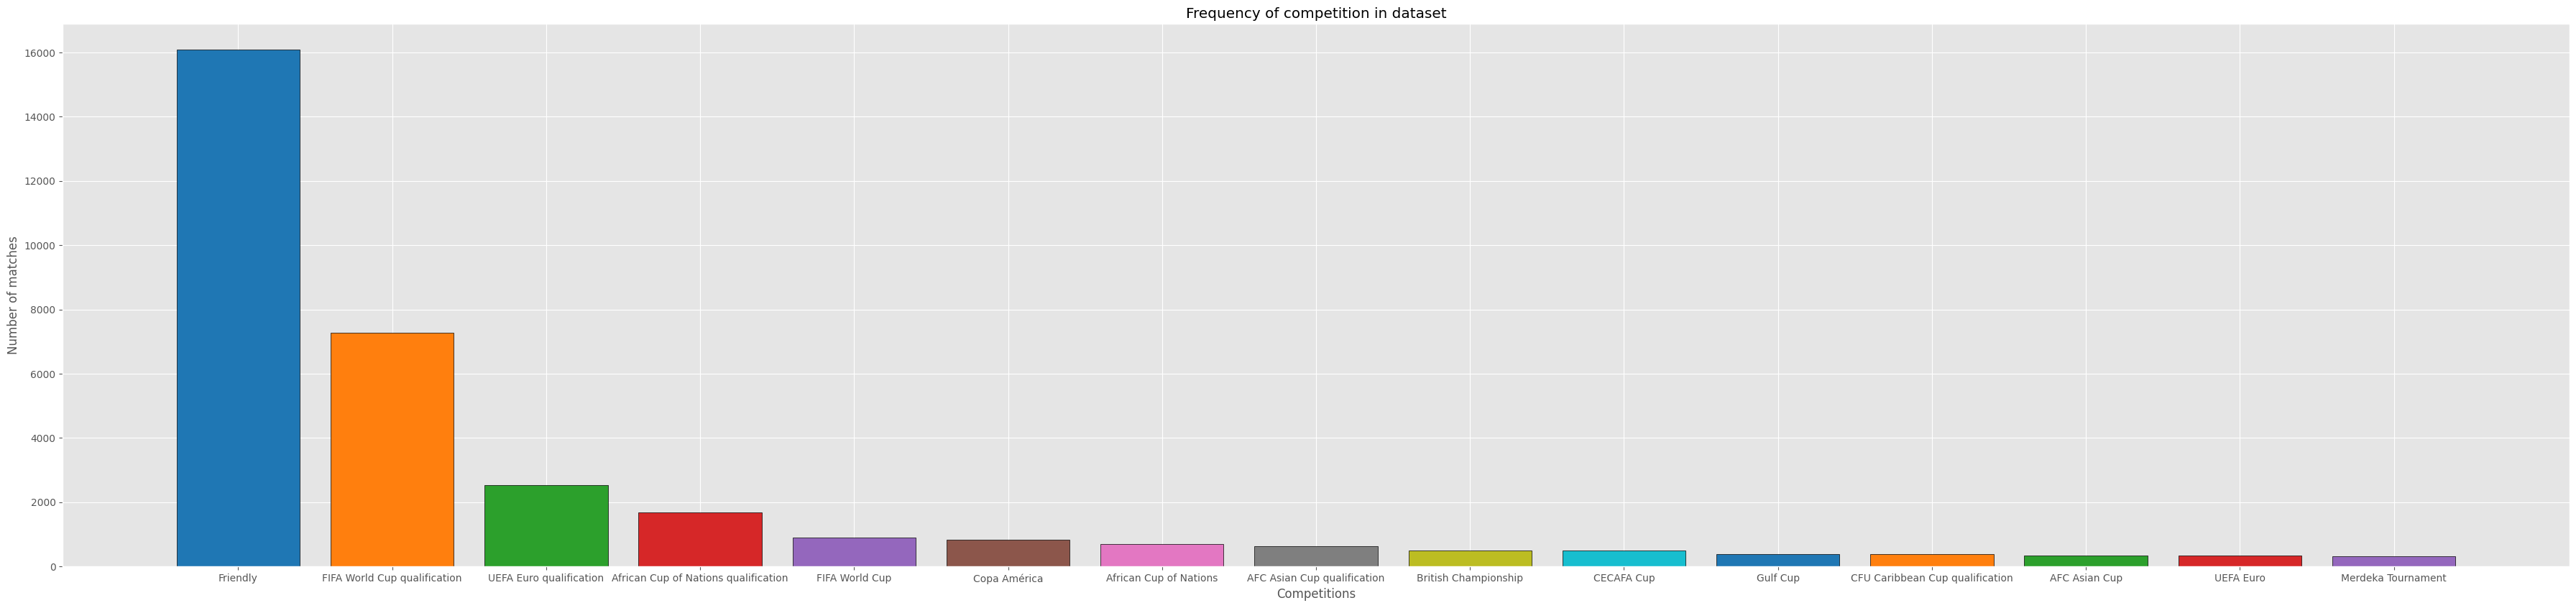

In [22]:
tournaments = df['tournament'].value_counts()

print("Number of tournaments: %d" % ( len(tournaments) ))

# Visto l'elevato numero di competizioni presenti, considero solo le prime 15 in base al numero di partite.

plt.title('Frequency of competition in dataset')
plt.ylabel('Number of matches')
plt.xlabel('Competitions')
plt.bar(tournaments.index[:15], tournaments.values[:15], color=[i for i in mcolors.TABLEAU_COLORS], edgecolor='black')

plt.show()

### Numero di partite disputate per anno

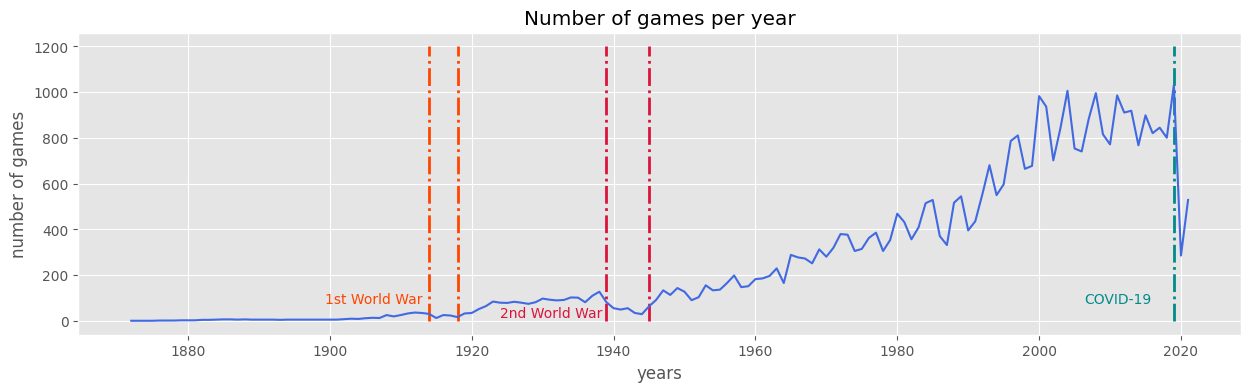

In [23]:
# matches per year
mpy = df['year'].value_counts().sort_index()

plt.figure(figsize=(15,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')

l1 = [(1914,0), (1914,1200)]
l2 = [(1918,0), (1918,1200)]
l3 = [(1939,0), (1939,1200)]
l4 = [(1945,0), (1945,1200)]
l5 = [(2019,0), (2019, 1200)]

lc = LineCollection([l1, l2, l3, l4, l5], color=["orangered","orangered", "crimson","crimson", "darkcyan"], lw=2, linestyles='-.')

plt.annotate('1st World War', xy=(1914, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='orangered')
plt.annotate('2nd World War', xy=(1939, 200), xycoords='data', ha='center', xytext=(-40, -30), textcoords='offset points', color='crimson')
plt.annotate('COVID-19', xy=(2019, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='darkcyan')

plt.gca().add_collection(lc)

plt.plot(mpy, color='royalblue')
plt.grid(True)
plt.show()

Si nota che il numero di match si è abbassato durante le Guerre Mondiali ed è drasticamente calato durante la pandemia di Covid-19 ad inizio 2020.

### Numero di partite giocate per anno in ogni continente
Dal dataset FIFA carico le confederazioni delle nazionali. Ricavo dunque i continenti in cui è stato disputato il match

In [24]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST,'fifa_ranking-2021-05-27.csv'))

df = get_continent_from_fifa(df, df_fifa)

All rows are correctly updated


In [25]:
# dataframe continent reduced
df_cr = df.groupby(['continent','year']).size().to_csv('output.csv') # risolvo il bug del groupby che non scrive in tutte le colonne i continenti
df_cr = pd.read_csv('output.csv')

df_cr.sort_values(by='year', axis=0, inplace=True)
df_cr = df_cr.reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if df.__len__() == df_cr['matches'].sum():
    print("Groupby eseguito correttamente")

years = df_cr['year'].drop_duplicates().to_numpy()

africa = df_cr[df_cr['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
america = df_cr[df_cr['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
asia = df_cr[df_cr['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])
europe = df_cr[df_cr['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
oceania = df_cr[df_cr['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])

print("First appearance in national match:\nAfrica: %d\nAmerica: %d\nAsia: %d\nEurope: %d\nOceania: %d" % (africa['year'].min(), america['year'].min(), asia['year'].min(), europe['year'].min(), oceania['year'].min() ))
africa  =  fix_continent_matches(years, africa)
america =  fix_continent_matches(years, america)
asia     = fix_continent_matches(years, asia)
europe  =  fix_continent_matches(years, europe)
oceania =  fix_continent_matches(years, oceania)

if len(africa) == len(europe) == len(america) == len(oceania) == len(asia):
    print("All df have the same number of rows")

Groupby eseguito correttamente
First appearance in national match:
Africa: 1926
America: 1885
Asia: 1917
Europe: 1872
Oceania: 1922
All df have the same number of rows


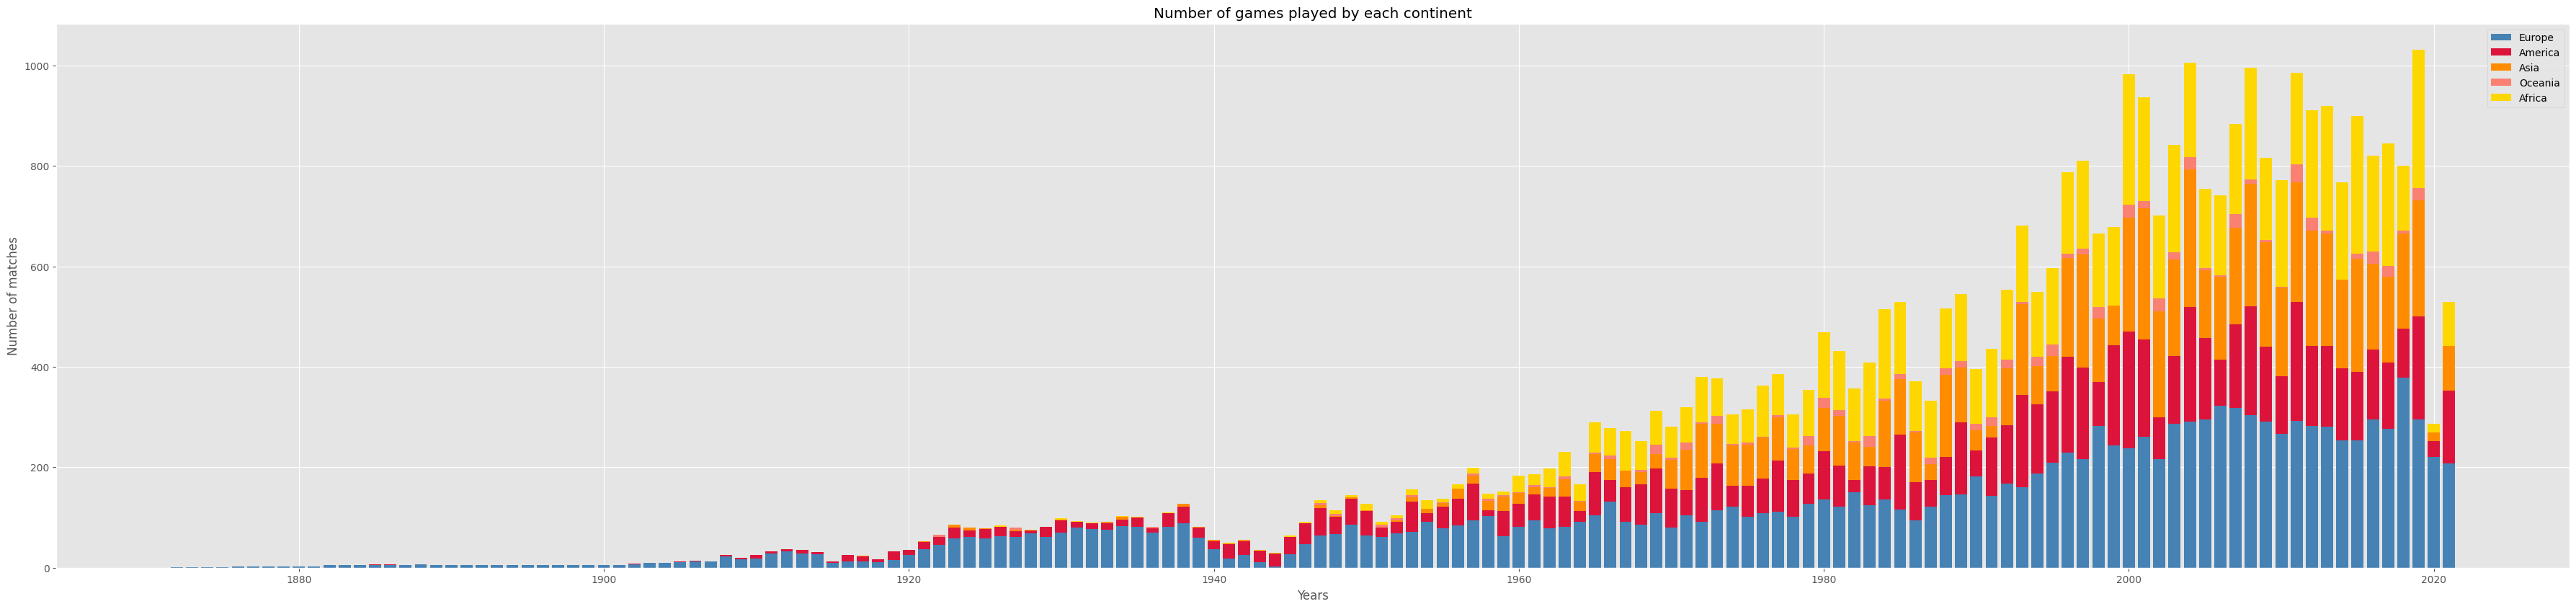

In [26]:
plt.title('Number of games played by each continent')
plt.ylabel('Number of matches')
plt.xlabel('Years')
plt.bar(years, europe.matches.values, color='steelblue')
plt.bar(years, america.matches.values, bottom=europe.matches.values , color='crimson')
plt.bar(years, asia.matches.values, bottom = europe.matches.values+america.matches.values, color='darkorange')
plt.bar(years, oceania.matches.values, bottom = europe.matches.values+america.matches.values+asia.matches.values , color='salmon')
plt.bar(years, africa.matches.values, bottom=europe.matches.values + america.matches.values + asia.matches.values + oceania.matches.values, color='gold')
plt.legend(['Europe', 'America', 'Asia', 'Oceania', 'Africa'])

plt.show()

Dal grafico si evince che Europa ed America sono i continenti dove si sono disputato più partite. Il numero di partite disputate in oceania è irrilevante rispetto al numero degli altri continenti nonostante l'Africa abbia disputato la prima partita ufficiale per ultima. <br>
Salvo comunque il dataframe per eventuali utilizzi

In [27]:
df.to_csv(path.join(PATH_DST, "dataset_v2_continent.csv"))

### Estrazione statistiche squadre presenti nel dataset

In [28]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v2_continent.csv')).drop(columns=['Unnamed: 0'])
# print(df.columns)

valid_country = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid_country.csv')).drop(columns=['Unnamed: 0']).team.values

df_country = df.country.drop_duplicates().values

# print(df_country)

not_valid_country = []

for i in df_country:
    if i not in valid_country:
        not_valid_country.append(i)
# print(not_valid_country)

# trovati altri record non validi. Li elimino

print("Lunghezza del dataframe prima del controllo: %s" % (len(df)) )

for i, row in df.iterrows():
    if(row.country in not_valid_country):
        df.drop(i, inplace=True)

print("Lunghezza del dataframe prima del controllo: %s" % (len(df)) )

df = df.reset_index(drop=True).to_csv(path.join(PATH_DST, 'dataset_v3.csv'))

Lunghezza del dataframe prima del controllo: 39029
Lunghezza del dataframe prima del controllo: 38205


In [29]:
# creo un dataframe con le statistiche di ogni squadra per vedere se ci sono delle correlazioni sul giocare in casa o no nello specifico
# e nei goal subiti/segnati
df = pd.read_csv(path.join(PATH_DST, 'dataset_v3.csv')).drop(columns=['Unnamed: 0'])

teams = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid_country.csv')).drop(columns=['Unnamed: 0'])

teams['games'] = 0
teams['home_games'] = 0
teams['away_games'] = 0
teams['neutral_games'] = 0

teams['wins'] = 0
teams['home_wins'] = 0
teams['away_wins'] = 0
teams['neutral_wins'] = 0
    
teams['defeats'] = 0
teams['home_defeats'] = 0
teams['away_defeats'] = 0
teams['neutral_defeats'] = 0

teams['draws'] = 0
teams['home_draws'] = 0
teams['away_draws'] = 0
teams['neutral_draws'] = 0

teams['goals_scored'] = 0
teams['home_goals_scored'] = 0
teams['away_goals_scored'] = 0
teams['neutral_goals_scored'] = 0

teams['goals_conceded'] = 0
teams['home_goals_conceded'] = 0
teams['away_goals_conceded'] = 0
teams['neutral_goals_conceded'] = 0

counter = 0
for team in teams.team.values:
    print('*** Processing %d/%d ***' % (counter, len(teams.team.values)), end='\r')

    team_df = df.query("home_team == @team or away_team == @team")

    home_games_df = team_df.query("neutral == False and country == @team ")
    away_games_df = team_df.query("neutral == False and country != @team ")
    neutral_games_df = team_df.query("neutral == True ")

    teams.at[teams.team == team, 'games'] = len(team_df)
    teams.at[teams.team == team, 'home_games'] = len(home_games_df)
    teams.at[teams.team == team, 'away_games'] = len(away_games_df)
    teams.at[teams.team == team, 'neutral_games'] = len(neutral_games_df)

        # non dovrebbe essere necessario fare tutti e 3 i controlli ma data la presneza di errori nel dataset lo faccio comunque
    query1 = "home_team == @team and outcome == 'Home' or away_team == @team and outcome == 'Away' "
    teams.at[teams.team == team, 'wins'] = len( team_df.query(query1) )
    teams.at[teams.team == team, 'home_wins'] = len(home_games_df.query(query1))
    teams.at[teams.team == team, 'away_wins'] = len(away_games_df.query(query1))
    teams.at[teams.team == team, 'neutral_wins'] = len(neutral_games_df.query(query1))

    query2 = "home_team == @team and outcome == 'Away' or away_team == @team and outcome == 'Home' "
    teams.at[teams.team == team, 'defeats'] = len( team_df.query(query2) )
    teams.at[teams.team == team, 'home_defeats'] = len(home_games_df.query(query2))
    teams.at[teams.team == team, 'away_defeats'] = len(away_games_df.query(query2))
    teams.at[teams.team == team, 'neutral_defeats'] = len(neutral_games_df.query(query2))

    query3 = "outcome == 'Draw' "
    teams.at[teams.team == team, 'draws'] = len(team_df.query(query3))
    teams.at[teams.team == team, 'home_draws'] = len(home_games_df.query(query3))
    teams.at[teams.team == team, 'away_draws'] = len(away_games_df.query(query3))
    teams.at[teams.team == team, 'neutral_draws'] = len(neutral_games_df.query(query3))

    teams.at[teams.team == team, 'goals_scored'] = team_df.query("home_team == @team")['home_score'].sum() + team_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'home_goals_scored'] = home_games_df.query("home_team == @team")['home_score'].sum() + home_games_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'away_goals_scored'] = away_games_df.query("home_team == @team")['home_score'].sum() + away_games_df.query("away_team == @team")['away_score'].sum()
    teams.at[teams.team == team, 'neutral_goals_scored'] = neutral_games_df.query("home_team == @team")['home_score'].sum() + neutral_games_df.query("away_team == @team")['away_score'].sum()

    teams.at[teams.team == team, 'goals_conceded'] = team_df.query("home_team == @team")['away_score'].sum() + team_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'home_goals_conceded'] = home_games_df.query("home_team == @team")['away_score'].sum() + home_games_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'away_goals_conceded'] = away_games_df.query("home_team == @team")['away_score'].sum() + away_games_df.query("away_team == @team")['home_score'].sum()
    teams.at[teams.team == team, 'neutral_goals_conceded'] = neutral_games_df.query("home_team == @team")['away_score'].sum() + neutral_games_df.query("away_team == @team")['home_score'].sum()

    counter = counter + 1

teams.to_csv(path.join(PATH_DST, 'teams_statistics.csv'))

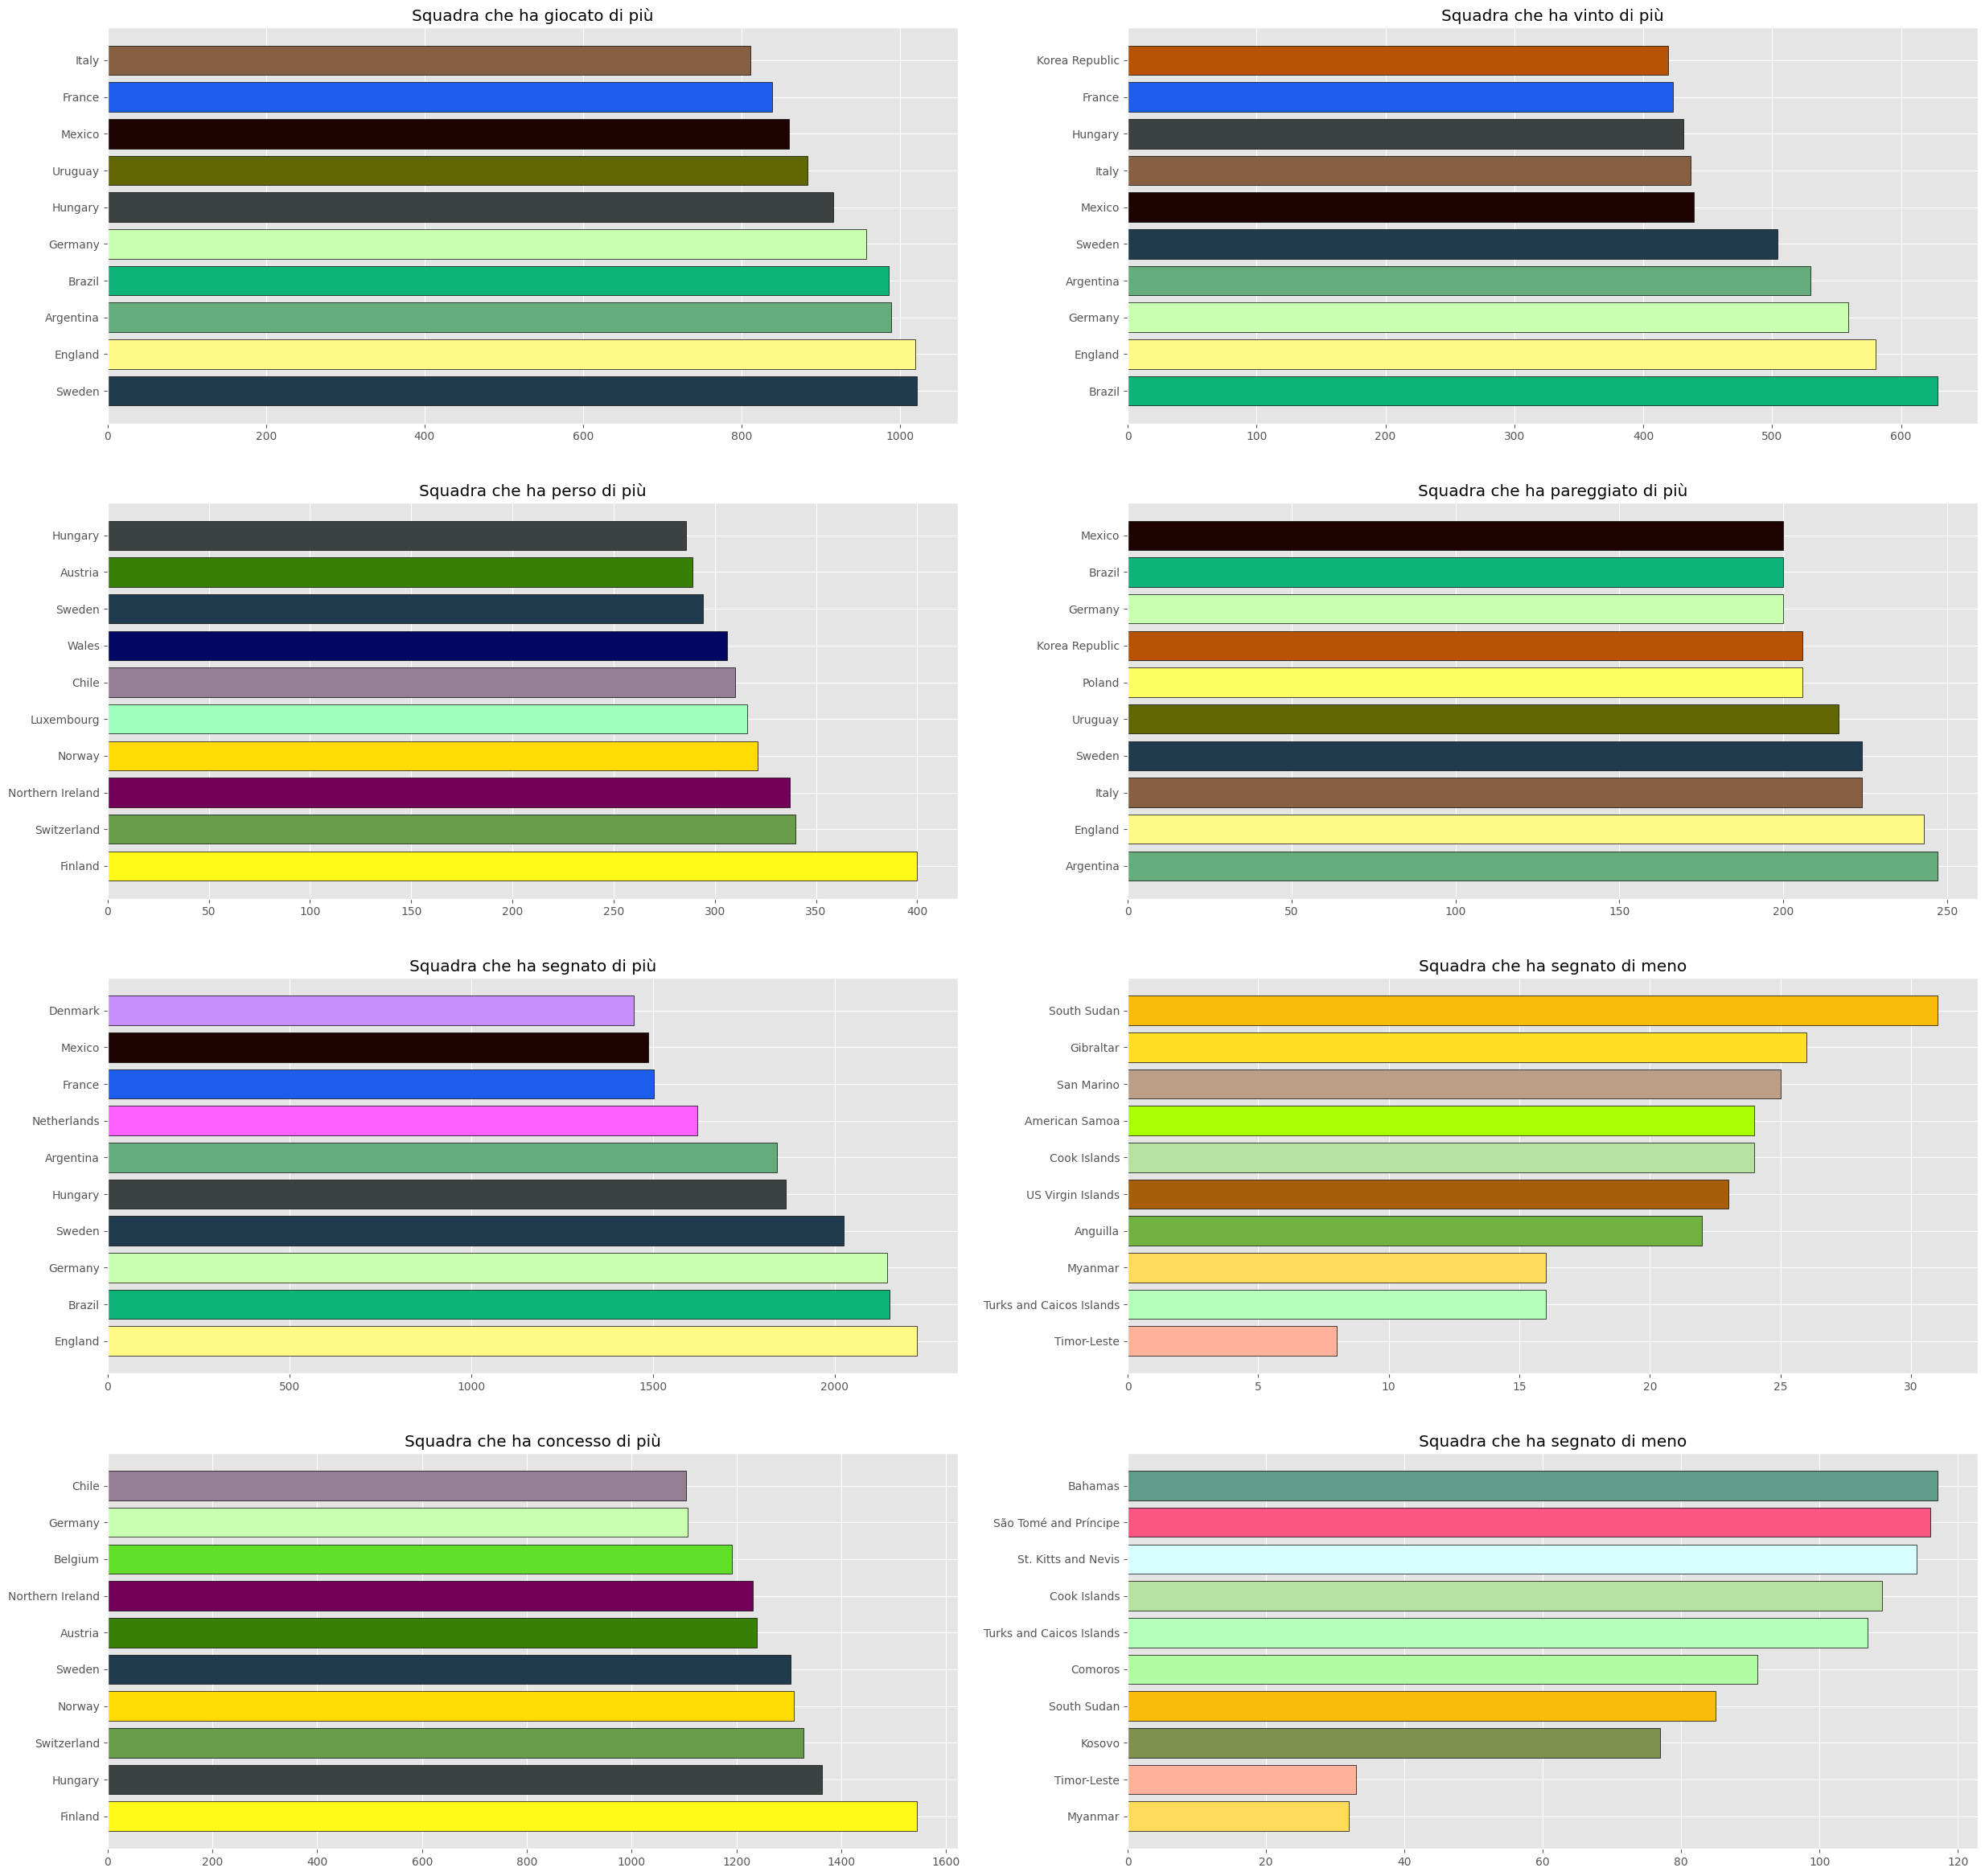

In [30]:
plt.rcParams.update({'figure.figsize':(30,30), 'figure.dpi':100})
fig, axs = plt.subplots(4, 2)

df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])
colors = list(mcolors.XKCD_COLORS)
df['color'] = colors[:len(df)]

df_axs = df.sort_values(by=['games'], ascending=False)
axs[0, 0].set_title("Squadra che ha giocato di più")
axs[0, 0].barh(df_axs.team.values[:10], df_axs.games.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['wins'], ascending=False)
axs[0, 1].set_title("Squadra che ha vinto di più")
axs[0, 1].barh(df_axs.team.values[:10], df_axs.wins.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['defeats'], ascending=False)
axs[1, 0].set_title("Squadra che ha perso di più")
axs[1, 0].barh(df_axs.team.values[:10], df_axs.defeats.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['draws'], ascending=False)
axs[1, 1].set_title("Squadra che ha pareggiato di più")
axs[1, 1].barh(df_axs.team.values[:10], df_axs.draws.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=False)
axs[2, 0].set_title("Squadra che ha segnato di più")
axs[2, 0].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_scored'], ascending=True)
axs[2, 1].set_title("Squadra che ha segnato di meno")
axs[2, 1].barh(df_axs.team.values[:10], df_axs.goals_scored.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=False)
axs[3, 0].set_title("Squadra che ha concesso di più")
axs[3, 0].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

df_axs = df.sort_values(by=['goals_conceded'], ascending=True)
axs[3, 1].set_title("Squadra che ha segnato di meno")
axs[3, 1].barh(df_axs.team.values[:10], df_axs.goals_conceded.values[:10], color=df_axs.color.values[:10], edgecolor='black')

plt.show()

correlazione di partite risultati di partite con goal fatti e subiti

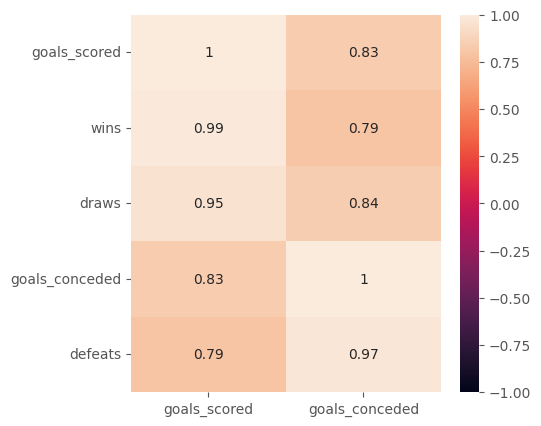

In [31]:
df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0','games', 'home_games', 'away_games',
    'neutral_games','home_wins', 'away_wins', 'neutral_wins','home_defeats', 'away_defeats', 'neutral_defeats','home_draws', 'away_draws', 'neutral_draws','home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored','home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

# sns.heatmap(df.corr(method='spearman'), annot=True)

plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(method='spearman')[['goals_scored','goals_conceded']].sort_values(by=['goals_scored','goals_conceded'], ascending=False), vmin=-1, vmax=1, annot=True)

plt.show()

correlazione tra partite giocate in casa/ fuori casa e partite neutrali/away/home

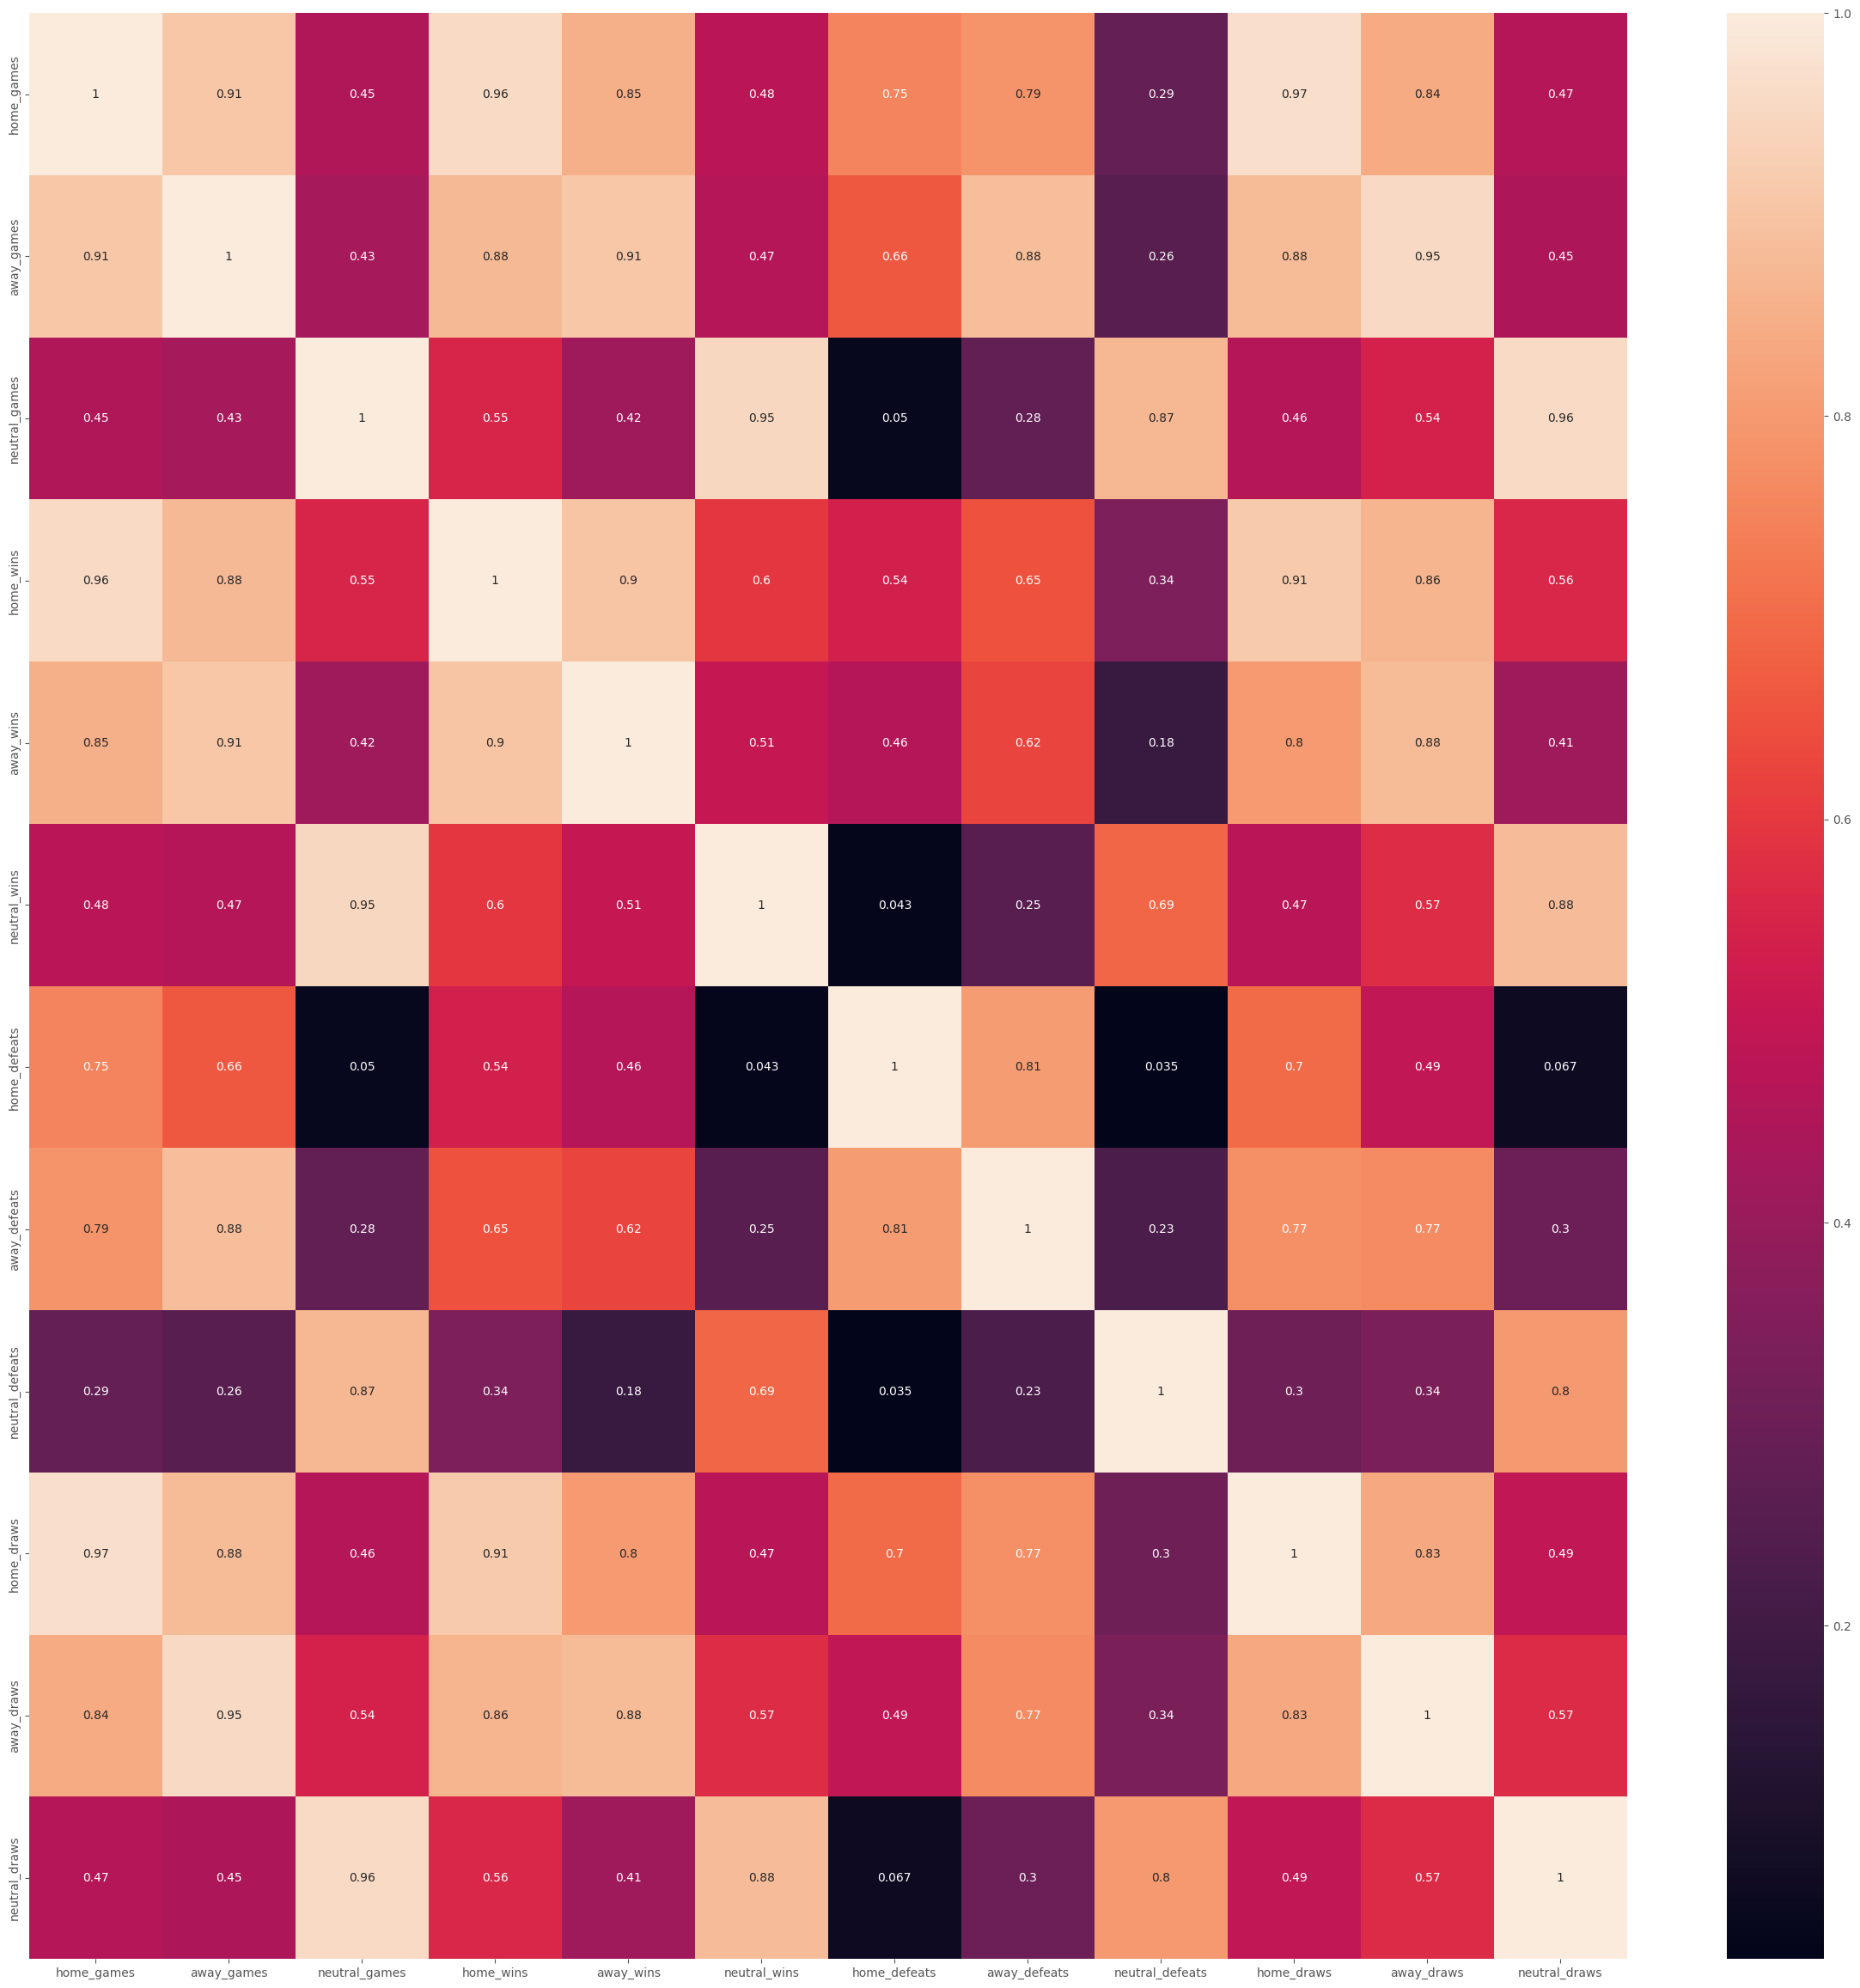

In [32]:
# df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0'])

# correlated = df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()
# correlated[1:15]

# strong_corr = correlated[(correlated >= .7) & (correlated <= 1)]
# moderate_corr = correlated[(correlated >= .3) & (correlated <= .7)]
# weak_corr = correlated[(correlated >= .0) & (correlated <= .3)]

# print(strong_corr.__len__())
# print(moderate_corr.__len__())
# print(weak_corr.__len__())
# print(strong_corr)
# strong_corr.to_csv("output.csv")

df = pd.read_csv(path.join(PATH_DST, 'teams_statistics.csv')).drop(columns=['Unnamed: 0', 'confederation', 'games','wins','defeats','draws','goals_scored', 'home_goals_scored', 'away_goals_scored',
    'neutral_goals_scored', 'goals_conceded', 'home_goals_conceded',
    'away_goals_conceded', 'neutral_goals_conceded'])

# df.columns.values

sns.heatmap(df.corr(),annot=True)
plt.show()

## Parte 3 - Modello predittivo di goal fatti e subiti 

In [33]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v3.csv')).drop(columns=['Unnamed: 0'])

Distribuzione dei goal segnati squadra di casa / squadra fuori casa

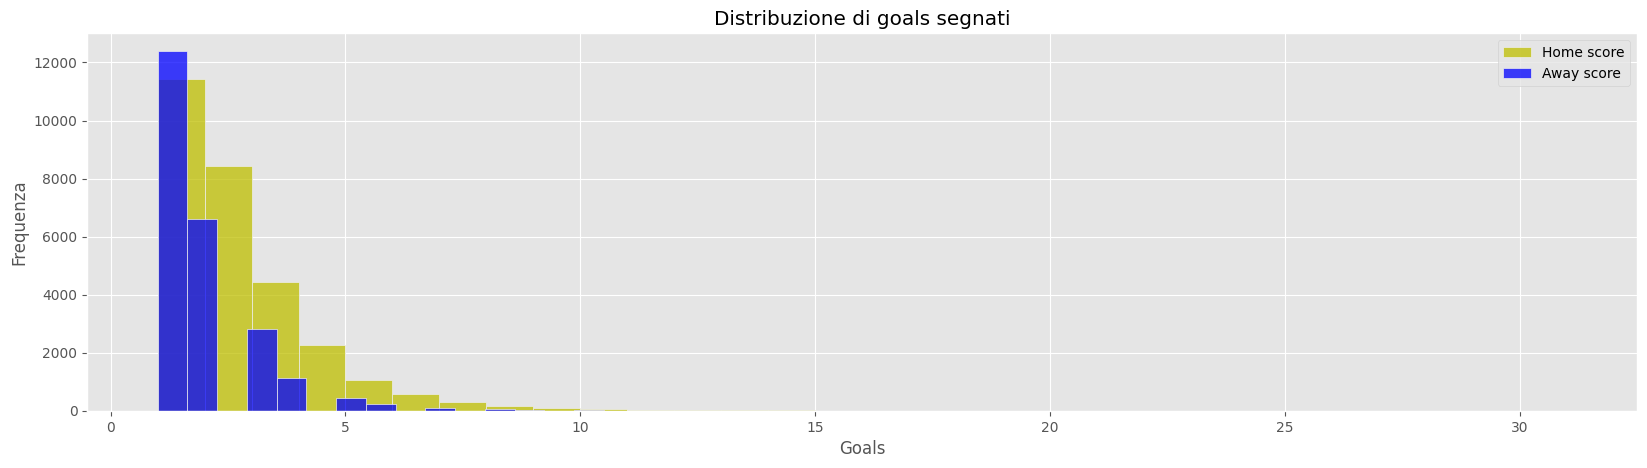

In [35]:
plt.figure(figsize=(20,5))
sns.histplot(df[df['home_score'] > 0]['home_score'], kde=False, bins=30, label="Home score", color="y")
sns.histplot(df[df['away_score'] > 0]['away_score'], kde=False, bins=30, label="Away score", color="b")
# plt.xticks([i for i in range(1,15)])
plt.legend()
plt.title("Distribuzione di goals segnati")
plt.xlabel("Goals")
plt.ylabel("Frequenza")
plt.show()

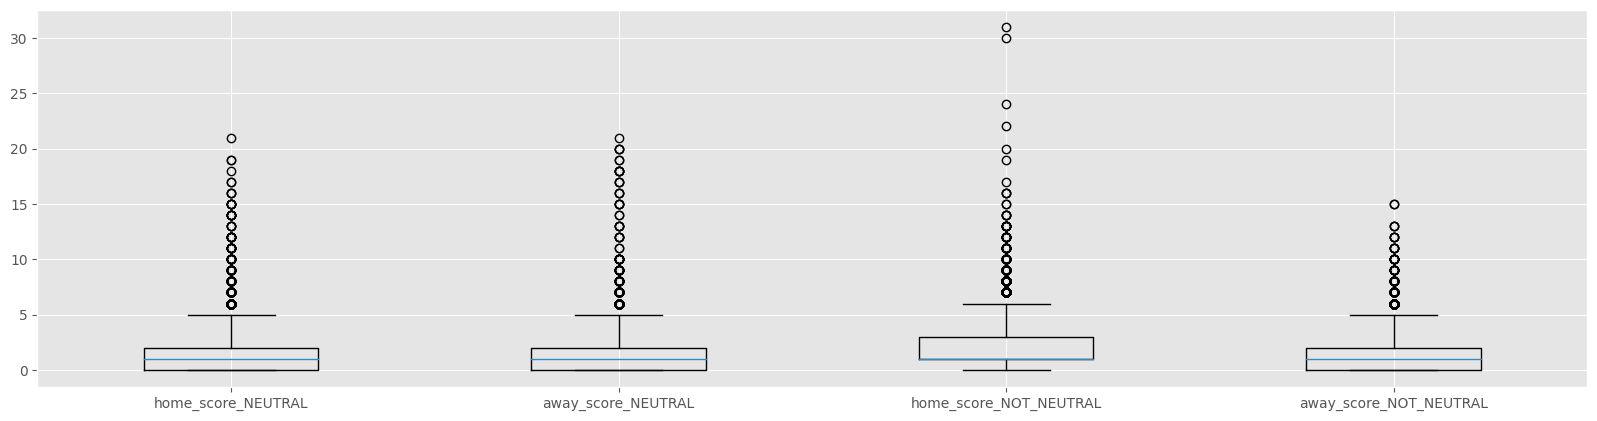

In [36]:
# boxplot con i goal medi delle squadre

neutral_games
not_neutral_games

plt.figure(figsize=(20,5))
scores = {
    'home_score_NEUTRAL': neutral_games['home_score'], 'away_score_NEUTRAL': neutral_games['away_score'],
    'home_score_NOT_NEUTRAL': not_neutral_games['home_score'], 'away_score_NOT_NEUTRAL': not_neutral_games['away_score'],
        }
plt.boxplot(scores.values())

ax = plt.gca()
ax.set_xticklabels(scores.keys())

plt.show()